# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn.ensemble import RandomForestClassifier

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv')

data loaded in 0.09501481056213379ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

In [3]:
calm_feature_idx = np.load('data/feature_idx_calm.npy')
angry_feature_idx = np.load('data/feature_idx_angry.npy')
disgust_feature_idx = np.load('data/feature_idx_disgust.npy')
fear_feature_idx = np.load('data/feature_idx_fear.npy')
happy_feature_idx = np.load('data/feature_idx_happy.npy')
neutral_feature_idx = np.load('data/feature_idx_neutral.npy')
sad_feature_idx = np.load('data/feature_idx_sad.npy')
surprised_feature_idx = np.load('data/feature_idx_surprised.npy')

In [4]:
neutral_feature_idx

array([  0,  37,  38,  41,  42,  50,  54,  56,  67,  74,  91, 108, 109,
       111, 141, 142, 146, 150, 156, 160, 165, 175, 180, 182, 184, 185,
       189, 204, 207, 211, 214, 216, 217, 220, 221, 224, 228, 238, 239,
       240, 241, 243, 245, 248, 250, 253, 256, 259])

In [5]:
combined_unique_indices = np.unique(np.concatenate((calm_feature_idx, 
                                                   angry_feature_idx,
                                                  disgust_feature_idx,
                                                  fear_feature_idx,
                                                  happy_feature_idx,
                                                  neutral_feature_idx,
                                                  sad_feature_idx,
                                                  surprised_feature_idx)))
combined_unique_indices.shape

(217,)

In [6]:
combined_unique_indices

array([  0,   2,   4,   5,   6,   7,   8,  10,  11,  12,  14,  15,  16,
        17,  18,  19,  21,  22,  24,  25,  27,  28,  29,  30,  31,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  79,  80,  83,  84,  85,  86,  88,  91,  97,  98, 102,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119,
       120, 123, 124, 125, 126, 128, 130, 136, 137, 138, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       158, 160, 161, 162, 163, 165, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 23

In [7]:
X_with_selected_features = pd.DataFrame(X.iloc[:, combined_unique_indices])
X_with_selected_features.shape

(1440, 217)

In [8]:
y

,0
0,surprised
1,happy
2,calm
3,happy
4,surprised
...,...
1435,surprised
1436,angry
1437,surprised
1438,disgust


In [9]:
label_mapping_dict = {'neutral': 1, 
                         'calm': 2, 
                         'happy': 3, 
                         'sad': 4, 
                         'angry': 5, 
                         'fear': 6, 
                         'disgust': 7, 
                         'surprised': 8}
y_converted = y.replace(label_mapping_dict)
y_converted

,0
0,8
1,3
2,2
3,3
4,8
...,...
1435,8
1436,5
1437,8
1438,7


# 5-fold CV (selected feature space)

In [11]:
group_members= data_loader.get_k_fold_group_member()
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_with_selected_features, y_converted, ID, group_members)

## GridSearch

In [15]:
n_estimators = [50, 100, 200]
max_depth = [None, 10, 20,30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

UAR_list = []
UAR_best = 0

for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        for a in range(len(min_samples_split)):
            for b in range(len(min_samples_leaf)):
                model = RandomForestClassifier(n_estimators = n_estimators[i],
                                               max_depth = max_depth[j],
                                               min_samples_split = min_samples_split[a],
                                               min_samples_leaf = min_samples_leaf[b],
                                               random_state = 42)
                UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
                if UAR_best<UAR:
                    UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
                    n_estimators_best = n_estimators[i]
                    max_depth_best = max_depth[j]
                    min_samples_split_best = min_samples_split[a]
                    min_samples_leaf_best = min_samples_leaf[b]
                    print(f"""
                    n_estimators = {n_estimators[i]}, 
                    max_depth = {max_depth[j]}, 
                    min_samples_split = {min_samples_split[a]},
                    min_samples_leaf = {min_samples_leaf[b]}
                    """)
                UAR_list.append(UAR) 

print(f"""
UAR_best = {UAR_best:.3f}, 
n_estimators_best = {n_estimators_best}, 
max_depth_best = {max_depth_best},
min_samples_split_best = {min_samples_split_best},
min_samples_leaf_best = {min_samples_leaf_best}
""")

  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423

                    n_estimators = 50, 
                    max_depth = None, 
                    min_samples_split = 2,
                    min_samples_leaf = 1
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.414


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.406


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.413


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.395


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.420


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.400


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.406


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.395


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.411


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.395


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.413


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.424

                    n_estimators = 50, 
                    max_depth = 10, 
                    min_samples_split = 10,
                    min_samples_leaf = 2
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.404


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.425

                    n_estimators = 50, 
                    max_depth = 20, 
                    min_samples_split = 2,
                    min_samples_leaf = 1
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.414


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.407


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.413


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.392


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.420


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.400


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.414


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.406


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.413


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.408


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.395


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.420


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.400


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.438

                    n_estimators = 100, 
                    max_depth = None, 
                    min_samples_split = 2,
                    min_samples_leaf = 1
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.421


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.414


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.419


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.419


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.417


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.415


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.419


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.415


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.417


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.424


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.411


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.439

                    n_estimators = 100, 
                    max_depth = 20, 
                    min_samples_split = 2,
                    min_samples_leaf = 1
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.421


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.424


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.415


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.419


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.438


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.421


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.414


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.419


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.427


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.432


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.439

                    n_estimators = 200, 
                    max_depth = None, 
                    min_samples_split = 5,
                    min_samples_leaf = 1
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.439


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.425


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.430


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.423


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.435


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.421


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.429


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.430


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.440

                    n_estimators = 200, 
                    max_depth = 20, 
                    min_samples_split = 5,
                    min_samples_leaf = 1
                    


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.439


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.425


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.427


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.432


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.439


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.439


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.428


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

UAR = 0.426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

UAR = 0.425

UAR_best = 0.440, 
n_estimators_best = 200, 
max_depth_best = 20,
min_samples_split_best = 5,
min_samples_leaf_best = 1



In [16]:
print(f"""
UAR_best = {UAR_best:.3f}, 
n_estimators_best = {n_estimators_best}, 
max_depth_best = {max_depth_best},
min_samples_split_best = {min_samples_split_best},
min_samples_leaf_best = {min_samples_leaf_best}
""")


UAR_best = 0.440, 
n_estimators_best = 200, 
max_depth_best = 20,
min_samples_split_best = 5,
min_samples_leaf_best = 1



## Result visualization

## Confusion matrix

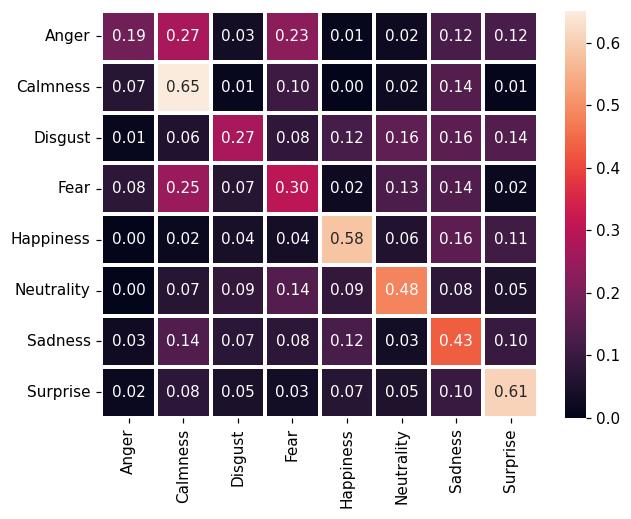

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [17]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)